## Importing the needed libraries

In [2]:
import numpy as np # array operations
import pandas as pd # dataframe operations
from scipy.stats import norm

# plotting
import matplotlib.pyplot as plt 
from matplotlib.ticker import (MultipleLocator,FormatStrFormatter,AutoMinorLocator)
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Machine learning related functions
from sklearn.preprocessing import StandardScaler #normalizinginputs
from sklearn.decomposition import PCA  # principal component analysis
from sklearn.gaussian_process import GaussianProcessRegressor 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from tqdm.auto import tqdm #progress bar 
from warnings import filterwarnings #disable warnings
filterwarnings('ignore')
from IPython import display 
%matplotlib inline

## uploading the dataset

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Rate_dataset.csv to Rate_dataset.csv


## Data Preprocessing

In [4]:
# read the dataset

df = pd.read_csv('Rate_dataset.csv', sep=",")

# remove missing values

df = df[df['Si/Al'].notna()]

# remove uncommon catalysts
df = df[df['Catalyst'] !='KL']
df = df[df['Catalyst'] !='KL (modified) *']
df = df[df['Catalyst'] !='H-MCM-22']
df = df[df['Catalyst'] !='Al-SBA15']
df = df[df['Catalyst'] !='BEA(modified) *']
df = df[df['Catalyst'] !='ZSM-5 (modified) *']
df = df[df['Catalyst'] !='USY (modified) *']

# convert the temperature from celcuis to Kelvin

df['T(k)'] = df['Temperature ( °C)']+273

In [5]:
# mount drive to save the plot pictures 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Compare the reaction rate constant obtained by two different methods

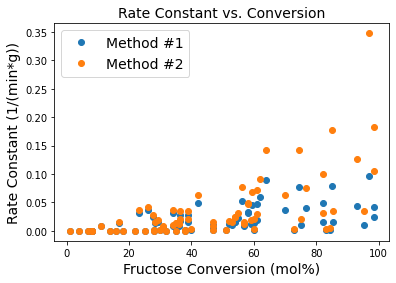

In [6]:
plt.plot(df[df['rate_constant_3(1/(min.g))']<=3.5]['Conversion_rate '], df[df['rate_constant_3(1/(min.g))']<=3.5]['rate_constant_1(1/(min.g))'], 'o', label = "Method #1")
plt.plot(df[df['rate_constant_3(1/(min.g))']<=3.5]['Conversion_rate '], df[df['rate_constant_3(1/(min.g))']<=3.5]['rate_constant_2(1/(min.g))'], 'o', label = "Method #2")
plt.xlabel("Fructose Conversion (mol%)", Fontsize = 14)
plt.ylabel("Rate Constant (1/(min*g))",Fontsize = 14)
plt.legend(fontsize = 14)
plt.title("Rate Constant vs. Conversion", fontsize = 14)
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/rate_conversion.png", bbox_inches='tight', dpi = 160)

### Proceed with Method #2

## Confirming First order kinetics using time dependent data from a paper

In [7]:
mass = 4      # grams
time = np.arange(30,330,30)
X_experimental= np.array([15,25,45,50,62,64,75,80,82,85])
S = np.array([15,27,40,46,42,45,41,40,39,38])

In [8]:
# k units are 1/(min*gram)
k = np.log(1/(1-X_experimental[-1]/100))*S[-1]/100/(time[-1]*mass) 
X_model = (1-np.exp((-1*k*time*mass)/(S/100)))*100

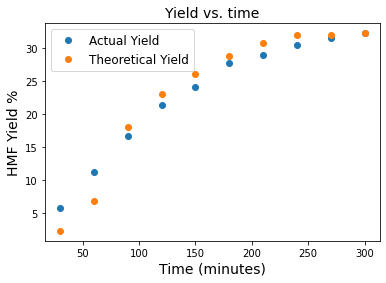

In [9]:
plt.plot(time,  X_model*S/100, 'o', label = "Actual Yield")
plt.plot(time, X_experimental*S/100, 'o', label = "Theoretical Yield")
plt.xlabel("Time (minutes)",Fontsize = 14)
plt.ylabel('HMF Yield %',Fontsize = 14)
plt.title("Yield vs. time",Fontsize = 14)
plt.legend(fontsize = 12)
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/time_model_yield.png", bbox_inches='tight', dpi = 160)

In [10]:
dictionary = {"Time":time,"X_experimental":X_experimental,"Selectivity":S, "X_theoritical": X_model}
dataframe = pd.DataFrame(dictionary)

In [11]:
dataframe

,Time,X_experimental,Selectivity,X_theoritical
0,30,15,15,38.159007
1,60,25,27,41.374718
2,90,45,40,41.764741
3,120,50,46,46.574094
4,150,62,42,57.608442
5,180,64,45,61.756916
6,210,75,41,70.794538
7,240,80,40,76.350097
8,270,82,39,81.054965
9,300,85,38,85.000000


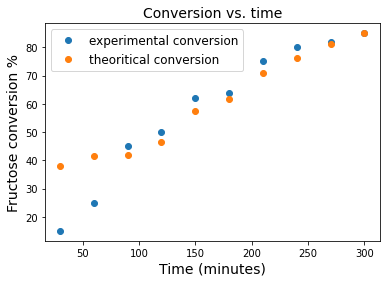

In [12]:
plt.plot(time, X_experimental, 'o', label = 'experimental conversion')
plt.plot(time, X_model, 'o', label = "theoritical conversion")
plt.xlabel("Time (minutes)",Fontsize = 14)
plt.ylabel('Fructose conversion %',Fontsize = 14)
plt.title("Conversion vs. time",Fontsize = 14)
plt.legend(fontsize = 12)
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/time_model_conversion.png", bbox_inches='tight', dpi = 160)

### Normalize all the rate constants to be at a temperature of 165°C using the Arrhenius equation

In [13]:
# constants
T_2 = 165+273
R = 8.314

In [14]:
# H-MOR zeolite calculation
Ea_mor = 141000
df_mor = df[df['Catalyst'] == 'H-MOR']
df_mor['normalized_k'] = df_mor['rate_constant_2(1/(min.g))']*np.exp(-(Ea_mor/R)*(1/T_2-1/df_mor['T(k)']))

In [15]:
# H-ZSM zeolite calculation
Ea_zsm = 132000
df_zsm = df[df['Catalyst'] == 'H-ZSM-5']
df_zsm['normalized_k'] = df_zsm['rate_constant_2(1/(min.g))']*np.exp(-(Ea_zsm/R)*(1/T_2-1/df_zsm['T(k)']))

In [16]:
# H-BEA zeolite calculation
Ea_bea = 142000
df_bea = df[df['Catalyst'] == 'H-BEA']
df_bea['normalized_k'] = df_bea['rate_constant_2(1/(min.g))']*np.exp(-(Ea_bea/R)*(1/T_2-1/df_bea['T(k)']))

In [17]:
# H-USY zeolite calculation
Ea_usy = 205000
df_usy = df[df['Catalyst'] == 'H-USY']
df_usy['normalized_k'] = df_usy['rate_constant_2(1/(min.g))']*np.exp(-(Ea_usy/R)*(1/T_2-1/df_usy['T(k)']))

In [18]:
frames = [df_mor, df_zsm ,df_bea, df_usy]
df_2 = pd.concat(frames)
df= df_2

### Handling typos

In [25]:
df.loc[df['Type of catalyst'] =='Transition Metal Zolite','Type of catalyst'] = 'Transition Metal Zeolite'
df.loc[df['Type of catalyst'] =='Protonated Zeolites','Type of catalyst'] = 'Protonated Zeolite'
df.loc[df['Solvent_system'] =='Single Phase','Solvent_system'] = 'Single phase'
df.loc[df['Solvent_system'] =='Biphasic ','Solvent_system'] = 'Biphasic'
df.loc[df['Phase_1'] =='water','Phase_1'] = 'Water'
df.loc[df['Phase_1'] =='Water ','Phase_1'] = 'Water'
df.loc[df['Phase_1'] =='THF ','Phase_1'] = 'THF'
df.loc[df['Phase_2'] =='THF ','Phase_2'] = 'THF'

### Handling missing values

In [27]:
#handling Nan
df['Phase_2'] = df['Phase_2'].fillna("one_phase")
for i in ['Surface_area_(m2/g)_BET','V(mic)_(cm3/g)','V(mesopore)_(cm3/g)','TPD_(NH3)_(micmol/g)','Lewis/Brosnted _acid_Sites','V(pore)_(cm3/g)']:
    df[i] = df[i].fillna(df.groupby('Catalyst')[i].transform('mean'))

### Removing outliers

In [28]:
# put a limit on high values because of data unavailability
df = df[df['normalized_k']<=0.4]
df.shape

(63, 41)

### Remove unimportant features

In [29]:
df = df.drop(columns=['Mass_Cat_(g)',	'Volume_(ml)'	,'Substrate_amount','Fructose Conversion','HMF Selectivity','initial_rate(mol/(L.min))',	'rate_constant(1/min)','Time (min)','M/Al (ie Sn, Cu..)','time_rate(min)'])
df = df[df['Si/Al'].notna()]

In [30]:
df = df.drop(columns=['Selectivity_rate ','Conversion_rate ','intial concentration(M)','T(k)','b ','normalized_constant','Solvent system', 'V(mesopore)_(cm3/g)'])

In [31]:
df =df.drop(columns=['Type of catalyst', 'Catalyst' , 'Phase_2','Lewis/Brosnted _acid_Sites','rate_constant_1(1/(min.g))','rate_constant_3(1/(min.g))'])

In [32]:
df.shape

(63, 17)

## Data Analysis

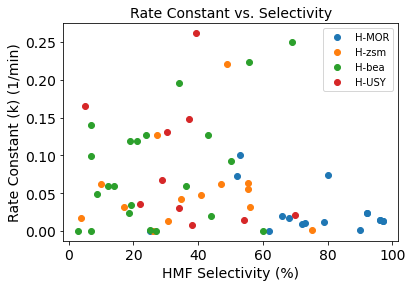

In [33]:
plt.plot(df_mor[df_mor['normalized_k']<=0.4]['Selectivity_rate '], df_mor[df_mor['normalized_k']<=0.4]['normalized_k'], 'o', label = "H-MOR")
plt.plot(df_zsm[df_zsm['normalized_k']<=0.4]['Selectivity_rate '], df_zsm[df_zsm['normalized_k']<=0.4]['normalized_k'], 'o', label = "H-zsm")
plt.plot(df_bea[df_bea['normalized_k']<=0.4]['Selectivity_rate '], df_bea[df_bea['normalized_k']<=0.4]['normalized_k'], 'o', label = "H-bea")
plt.plot(df_usy[df_usy['normalized_k']<=0.4]['Selectivity_rate '], df_usy[df_usy['normalized_k']<=0.4]['normalized_k'], 'o', label = "H-USY")
plt.legend()
plt.xlabel("HMF Selectivity (%)", fontsize=14)
plt.ylabel("Rate Constant (k) (1/min)",fontsize=14)
plt.title("Rate Constant vs. Selectivity", fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/Selectivity_conversion_1.png", bbox_inches='tight', dpi = 160)

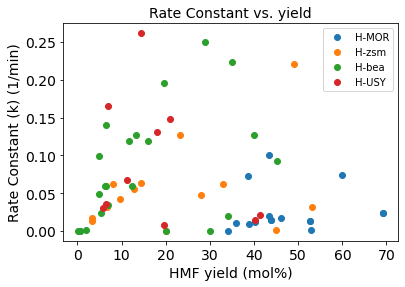

In [34]:
plt.plot(df_mor[df_mor['normalized_k']<=0.4]['HMF Yield'], df_mor[df_mor['normalized_k']<=0.4]['normalized_k'], 'o', label = "H-MOR")
plt.plot(df_zsm[df_zsm['normalized_k']<=0.4]['HMF Yield'], df_zsm[df_zsm['normalized_k']<=0.4]['normalized_k'], 'o', label = "H-zsm")
plt.plot(df_bea[df_bea['normalized_k']<=0.4]['HMF Yield'], df_bea[df_bea['normalized_k']<=0.4]['normalized_k'], 'o', label = "H-bea")
plt.plot(df_usy[df_usy['normalized_k']<=0.4]['HMF Yield'], df_usy[df_usy['normalized_k']<=0.4]['normalized_k'], 'o', label = "H-USY")
plt.legend()
plt.xlabel("HMF yield (mol%)", fontsize=14)
plt.ylabel("Rate Constant (k) (1/min)",fontsize=14)
plt.title("Rate Constant vs. yield", fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/rate_yield.png", bbox_inches='tight', dpi = 160)

In [43]:
df["Solvent_system"].unique()

array(['Biphasic', 'Single phase'], dtype=object)

In [44]:
df_2 = df[df['Solvent_system']=="Single phase"]

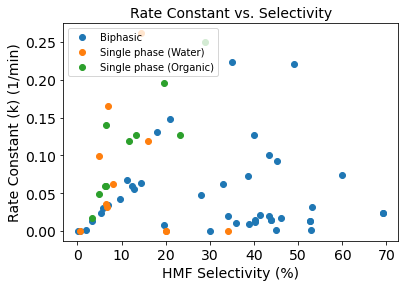

In [45]:
plt.plot(df[df['Solvent_system']=='Biphasic']['HMF Yield'],df[df['Solvent_system']=='Biphasic']['normalized_k'],'o', label = "Biphasic")
plt.plot(df_2[df_2['Phase_1']== "Water"]['HMF Yield'],df_2[df_2['Phase_1']== "Water"]['normalized_k'],'o', label ="Single phase (Water)" )
plt.plot(df_2[df_2['Phase_1']!= "Water"]['HMF Yield'],df_2[df_2['Phase_1']!= "Water"]['normalized_k'],'o', label ="Single phase (Organic)" )
plt.legend(loc= 'upper left')
plt.xlabel("HMF Selectivity (%)", fontsize=14)
plt.ylabel("Rate Constant (k) (1/min)",fontsize=14)
plt.title("Rate Constant vs. Selectivity", fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/Selectivity_conversion.png", bbox_inches='tight', dpi = 160)

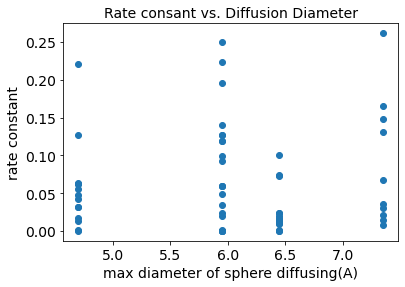

In [46]:
plt.plot(df['max_diameter_sphere_diffusing(A)'], df['normalized_k'], 'o')
plt.xlabel('max diameter of sphere diffusing(A)', fontsize=14)
plt.ylabel('rate constant', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Rate consant vs. Diffusion Diameter", fontsize = 14)
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/yield_diameter.png", bbox_inches='tight', dpi = 160)

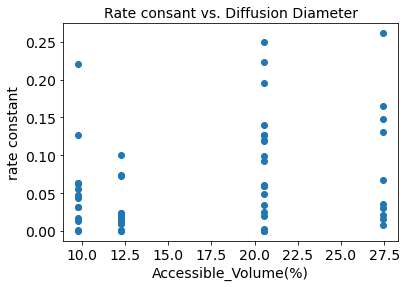

In [47]:
plt.plot(df['Accessible_Volume(%)'], df['normalized_k'], 'o')
plt.xlabel('Accessible_Volume(%)',fontsize=14)
plt.ylabel('rate constant',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Rate consant vs. Diffusion Diameter", fontsize = 14)
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/yield_diameter.png", bbox_inches='tight', dpi = 160)

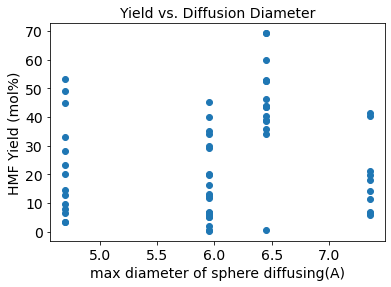

In [48]:
plt.plot(df[df['HMF Yield']<=80]['max_diameter_sphere_diffusing(A)'], df[df['HMF Yield']<=80]['HMF Yield'], 'o')
plt.xlabel('max diameter of sphere diffusing(A)',fontsize=14)
plt.ylabel('HMF Yield (mol%)',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Yield vs. Diffusion Diameter", fontsize = 14)
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/yield_diameter.png", bbox_inches='tight', dpi = 160)

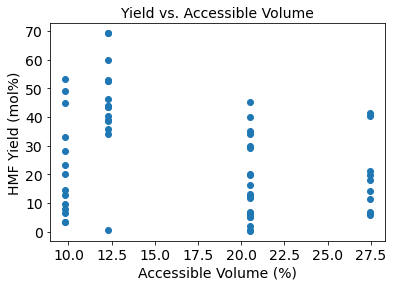

In [49]:
plt.plot(df[df['HMF Yield']<=80]['Accessible_Volume(%)'], df[df['HMF Yield']<=80]['HMF Yield'], 'o')
plt.xlabel('Accessible Volume (%)',fontsize=14)
plt.ylabel('HMF Yield (mol%)',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Yield vs. Accessible Volume", fontsize = 14)
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/Yield_access_vol.png", bbox_inches='tight', dpi = 160)

In [50]:
df =df.drop(columns=['Phase_1', 'Solvent_system', 'Avg_pore_diameter(nm)','Surface_area_(m2/g)_BET','V(pore)_(cm3/g)','V(mic)_(cm3/g)'])

## Regression

In [51]:
# 'Temperature ( °C)'
features = df.drop(columns = ['normalized_k',"HMF Yield"]).values
feature_list = list(df.drop(columns = ['normalized_k',"HMF Yield"]).columns)
labels = df['normalized_k'].values

In [52]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.2, random_state = 42)

In [53]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (50, 9)
Training Labels Shape: (50,)
Testing Features Shape: (13, 9)
Testing Labels Shape: (13,)


In [54]:
# The baseline predictions are the historical averages
baseline_preds = np.mean(test_labels)
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 5))

Average baseline error:  0.02802


### Random Hyperparameter search for Random forest

In [55]:
# use random research to find the best hyperparameters for RF
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [56]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_features, train_labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.1min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [57]:
rf_random.best_estimator_

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=400, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [58]:
#best_random.fit(train_features, train_labels)
best_random = rf_random.best_estimator_
best_random.fit(train_features, train_labels)
random_accuracy = best_random.score(test_features, test_labels)

### Compare Random Forest with a baseline model

In [59]:
base_model = RandomForestRegressor(n_estimators = 1000, random_state = 42)
base_model.fit(train_features, train_labels)
base_accuracy = base_model.score(test_features, test_labels)

In [60]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of -1.76%.


### Random Forest Training

In [61]:
rf  = best_random
rf.fit(train_features, train_labels)

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=400, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [62]:
# Use the forest's predict method on the test data
train_pred = rf.predict(train_features)
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors_train = (train_pred - train_labels)**2
errors = (predictions - test_labels)**2
# Print out the mean absolute error (mae)
print('Mean Absolute Error(train):', round(np.sqrt(np.mean(errors_train)), 5), 'degrees.')
print('Mean Absolute Error(test):', round(np.sqrt(np.mean(errors)), 5), 'degrees.')

Mean Absolute Error(train): 8e-05 degrees.
Mean Absolute Error(test): 0.01251 degrees.


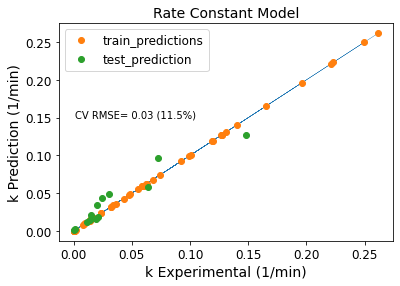

In [63]:
#print("Accuracy = ", rf.score(train_features,train_labels)*100)
plt.plot(train_labels, train_labels, '-',linewidth=0.2,color = '#1f77b4')
plt.plot(train_labels,train_pred , 'o',color = '#ff7f0e', label='train_predictions')
plt.plot(test_labels,predictions , 'o',color = '#2ca02c', label ='test_prediction')
plt.text(0.001,0.15,'CV RMSE= 0.03 (11.5%)')
plt.style.use('seaborn-pastel')

plt.title('Rate Constant Model', fontsize= 14)
plt.xlabel('k Experimental (1/min)', fontsize= 14)
plt.ylabel('k Prediction (1/min)',fontsize= 14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/rate_train_final.png", bbox_inches='tight', dpi = 160)

### Feature importance

In [64]:
from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(rf, prefit= True)

In [65]:
# Get numerical feature importances
importances = list(base_model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: rate_constant_2(1/(min.g)) Importance: 0.61
Variable: TPD_(NH3)_(micmol/g) Importance: 0.14
Variable: catalyst_substrate_loading Importance: 0.07
Variable: Total_dipole_moment(D) Importance: 0.05
Variable: Temperature ( °C)    Importance: 0.05
Variable: Si/Al                Importance: 0.03
Variable: Accessible_Volume(%) Importance: 0.03
Variable: max_diameter_sphere_diffusing(A) Importance: 0.02
Variable: phase_2/phase_1      Importance: 0.02


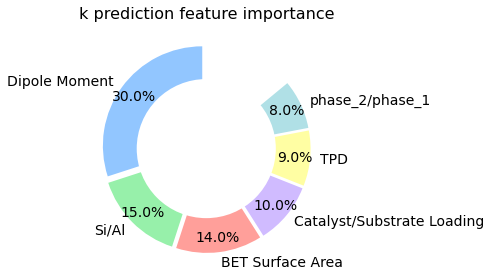

In [66]:
labels= ["Dipole Moment", "Si/Al", "BET Surface Area", "Catalyst/Substrate Loading","TPD", "phase_2/phase_1"]
sizes = [0.3,0.15,0.14,0.1,0.09,0.08]
#colors
#colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
plt.title("k prediction feature importance", size = 16)

#explsion
explode = (0.05,0.05,0.05,0.05, 0.05,0.05)
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode,  textprops={'fontsize': 14})
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
#ax1.axis('equal')  
plt.tight_layout()
images_dir = '/content/gdrive/My Drive'
plt.savefig(f"{images_dir}/feature_importance_1.png", dpi = 160)

### Evaluate performance using K-fold cross Validation

In [69]:
# 'Temperature ( °C)'
features = df.drop(columns = ['normalized_k',"HMF Yield"]).values
feature_list = list(df.drop(columns = ['normalized_k',"HMF Yield"]).columns)
labels = df['normalized_k'].values

In [70]:
# New random forest with only the two most important variables
model = best_random 
cv = KFold(n_splits=5, random_state=1, shuffle=True)
scores = cross_val_score(model, features, labels, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# report performance
print('RMSE: %.4f (%.4f)' % (np.abs(mean(scores)), np.std(scores)))
#print('accuracy %.3f (%.3f)' % (np.abs(mean(model.score)), std(scores)))

RMSE: 0.0298 (0.0149)


In [71]:
# spanning range scaled error
range = np.max(labels)-np.min(labels)
print("scaled error: %.1f" % (np.abs(mean(scores))/range*100),"%")

scaled error: 11.4 %
